In [1]:
# Run some setup code for this notebook.
import random
import numpy as np
import matplotlib.pyplot as plt


# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2



In [2]:
import os
import pickle

def unpickle(filename):
    """ 载入cifar数据集的一个batch """
    with open(filename, 'rb') as f:
        datadict = pickle.load(f,encoding='latin1')
    return datadict


def load_CIFAR_batch(filename):
        datadict = unpickle(filename)
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("float")
        Y = np.array(Y)
        return X, Y

def load_CIFAR10(ROOT):
    """ 载入cifar全部数据 """
    xs = []
    ys = []
    for b in range(1, 6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b,))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

In [3]:
cifar10_dir = '../cifar'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [4]:
meta = unpickle(cifar10_dir+'/batches.meta');
meta
classes = meta['label_names']
print(np.shape(classes))
classes

(10,)


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

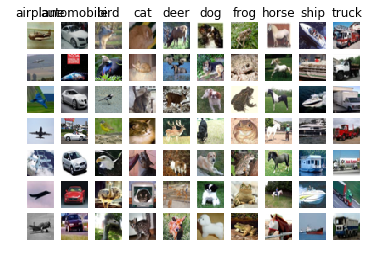

In [5]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)   #返回非0元素的索引
    idxs = np.random.choice(idxs, samples_per_class, replace=False)  #随机取样，不放回的取出samples_per_class个
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [6]:
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
train_add = np.ones(X_train.shape[0])    #在末尾加一个1
test_add = np.ones(X_test.shape[0])
X_train = np.column_stack((X_train,train_add))
X_test = np.column_stack((X_test,test_add))
print(X_train.shape, X_test.shape)

(50000, 3073) (10000, 3073)


In [7]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_dev = 500
num_test = 10000


mask = list(range(num_training,num_training + num_validation))
X_val = X_train[mask]
y_val = y_train[mask]

mask = np.random.choice(num_training, num_dev, replace = False)
X_dev = X_train[mask]
y_dev = y_train[mask]

mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('development data shape: ', X_dev.shape)
print('development labels shape: ', y_dev.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
development data shape:  (500, 3073)
development labels shape:  (500,)
Test data shape:  (10000, 3073)
Test labels shape:  (10000,)


![avatar](./a.png)

梯度是上升最快的方向
![avatar](./b.jpg)

In [9]:
def Gradient_Descent(W,X,y,reg):
    dW = np.zeros(W.shape)
    #print(dW.shape)
    #print(X_train.shape)
    loss = 0.0
    classes_num = W.shape[1]
    train_num = X.shape[0]

    for i in range(train_num):
        S = X[i].dot(W)
        correct_s = S[y[i]]
        for j in range(classes_num):
            if j == y[i]:
                continue
            margin = S[j] - correct_s + 1
            if margin > 0:
                loss += margin
                dW[:,j] += X[i]
                dW[:,y[i]] -= X[i]

    loss /= train_num
    dW /= train_num
    dW += reg*W   #regularize the weights
    loss += 0.5 * reg * np.sum(W*W)
    #dW /= np.linalg.norm(dW,ord=None)
    
    return loss, dW

In [43]:
from numpy import random
class SVM(object):
    def __init__(self):
        self.W = None
        pass
    
    def train(self, X, y, step=1e-3, reg=1e-5, times=5000):
        classes_num = np.max(y)+1
        if self.W is None:
            self.W = 0.001 * random.randn(X.shape[1],classes_num)
        for i in range(times):
            loss, delta_W = Gradient_Descent(self.W, X, y, reg)
            print('i    ',i)
            #print(delta_W)
            print('loss ',loss)
            num_validation = X_val.shape[0]
            S = X_val.dot(self.W)
            Ypred = np.zeros(num_validation)
            for j in range(num_validation):
                Ypred[j] = np.argmax(S[j])
            accuracy = np.mean(Ypred==y_val)
            print('accuracy ',accuracy)
            
            self.W -= delta_W * step
            #print(self.W)
            #print(Ypred)
   
    def predict(self, X, y):
        num_test = X.shape[0]
        S = X.dot(self.W)
        
        Ypred = np.zeros(num_test)
        
        for i in range(num_test):
            Ypred[i] = np.argmax(S[i])
            
        return Ypred
        

In [44]:
mysvm = SVM()

In [ ]:
mysvm.train(X_train,y_train)

i     0
loss  39.38627498137659
accuracy  0.128
i     1
loss  127638.51149494636
accuracy  0.113
i     2
loss  24270.408616250734
accuracy  0.163
i     3
loss  114420.88527281322
accuracy  0.114
i     4
loss  35086.57987310106
accuracy  0.087
i     5
loss  99016.60968639598
accuracy  0.16
i     6
loss  44947.540092039104
accuracy  0.093
i     7
loss  84031.25327530339
accuracy  0.158
i     8
loss  55662.30456581271
accuracy  0.087
i     9
loss  69544.31776242219
accuracy  0.16
i     10
loss  60897.1165551633
accuracy  0.127
i     11
loss  60434.48393349581
accuracy  0.161
i     12
loss  67844.75824777904
accuracy  0.122
i     13
loss  51842.53181850895
accuracy  0.159
i     14
loss  72017.62929730925
accuracy  0.095
i     15
loss  45604.7952980375
accuracy  0.16
i     16
loss  73276.07288847899
accuracy  0.102
i     17
loss  42644.20616775678
accuracy  0.161
i     18
loss  72515.4254215956
accuracy  0.114
i     19
loss  41811.92365008394
accuracy  0.163
i     20
loss  70753.2145518479


i     167
loss  36148.722632449826
accuracy  0.265
i     168
loss  39763.74430870137
accuracy  0.23
i     169
loss  36085.995613769155
accuracy  0.266
i     170
loss  39684.01804769836
accuracy  0.23
i     171
loss  36016.87603792519
accuracy  0.267
i     172
loss  39611.894875090125
accuracy  0.231
i     173
loss  35949.67745860373
accuracy  0.267
i     174
loss  39517.205773998
accuracy  0.231
i     175
loss  35898.74783217013
accuracy  0.267
i     176
loss  39417.9178816713
accuracy  0.229
i     177
loss  35844.77106257311
accuracy  0.268
i     178
loss  39348.531770085516
accuracy  0.229
i     179
loss  35786.69848318824
accuracy  0.27
i     180
loss  39251.32149100146
accuracy  0.229
i     181
loss  35727.91883811289
accuracy  0.27
i     182
loss  39168.31877117597
accuracy  0.229
i     183
loss  35666.72982127486
accuracy  0.27
i     184
loss  39100.33353084738
accuracy  0.229
i     185
loss  35612.95420468774
accuracy  0.269
i     186
loss  39033.67732644116
accuracy  0.229
i   

i     331
loss  32594.589871007258
accuracy  0.279
i     332
loss  35954.14973580522
accuracy  0.231
i     333
loss  32569.834488495195
accuracy  0.282
i     334
loss  35925.89020255903
accuracy  0.231
i     335
loss  32550.092122458966
accuracy  0.282
i     336
loss  35895.536433620815
accuracy  0.231
i     337
loss  32526.28486055848
accuracy  0.282
i     338
loss  35861.732575458904
accuracy  0.23
i     339
loss  32499.626387521497
accuracy  0.282
i     340
loss  35833.5356598216
accuracy  0.23
i     341
loss  32475.833031569393
accuracy  0.282
i     342
loss  35814.12070491981
accuracy  0.23
i     343
loss  32451.490825134228
accuracy  0.282
i     344
loss  35794.72785812299
accuracy  0.23
i     345
loss  32412.4116850791
accuracy  0.282
i     346
loss  35758.950728490636
accuracy  0.23
i     347
loss  32397.673009031176
accuracy  0.282
i     348
loss  35739.950384429554
accuracy  0.231
i     349
loss  32363.945007906455
accuracy  0.282
i     350
loss  35726.350060180775
accuracy  

i     494
loss  34353.87676031409
accuracy  0.233
i     495
loss  30889.048741009123
accuracy  0.289
i     496
loss  34338.24234664784
accuracy  0.233
i     497
loss  30874.1420006558
accuracy  0.289
i     498
loss  34316.187880565776
accuracy  0.233
i     499
loss  30868.11910665675
accuracy  0.289
i     500
loss  34296.24846035968
accuracy  0.233
i     501
loss  30857.590362710383
accuracy  0.288
i     502
loss  34278.67407791513
accuracy  0.233
i     503
loss  30843.40509499861
accuracy  0.288
i     504
loss  34257.44895599009
accuracy  0.233
i     505
loss  30824.928024425415
accuracy  0.289
i     506
loss  34238.796848670805
accuracy  0.233
i     507
loss  30819.34445387902
accuracy  0.289
i     508
loss  34224.69235794623
accuracy  0.233
i     509
loss  30803.099462985283
accuracy  0.289
i     510
loss  34209.59756069425
accuracy  0.233
i     511
loss  30787.349097838873
accuracy  0.289
i     512
loss  34201.82012970681
accuracy  0.233
i     513
loss  30770.06476136526
accuracy  

In [28]:
Y_predict = mysvm.predict(X_test, y_test)

accuracy = np.mean(Y_predict==y_test)
print(accuracy)

0.1568
